<a href="https://colab.research.google.com/github/yadukrishnanp2001/Question-Answering-on-Squad-Dataset---An-encoder-only-Architecture/blob/main/Q%26A_03_improved_architecture_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cell 1 essentially serves to load the SQuAD data, reduce the dataset size for faster processing, and then give a quick look at a sample entry to verify that the data has been loaded correctly.

In your encoder part later on, you'll likely use this data to predict which word in the context is the answer and provide confidence scores for the prediction. This cell lays the groundwork by ensuring the data is correctly loaded and structured before you move on to model building and inference.

In [ ]:
# Cell 1: Load and Inspect Data
import json
import torch
import torch.nn as nn
from collections import Counter


import json

with open('/content/train-v2.0.json') as f:
    squad_data = json.load(f)

# Take 50% of data
sample_data = squad_data['data'][:int(len(squad_data['data'])*0.5)]

# Print sample structure
print("Sample Context + Question:")
print("-"*50)
print("Title:", sample_data[0]['title'])
print("Context:", sample_data[0]['paragraphs'][0]['context'][:100] + "...")
print("Question:", sample_data[0]['paragraphs'][0]['qas'][0]['question'])
print("Answer:", sample_data[0]['paragraphs'][0]['qas'][0]['answers'][0]['text'])

Sample Context + Question:
--------------------------------------------------
Title: Beyoncé
Context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American si...
Question: When did Beyonce start becoming popular?
Answer: in the late 1990s


 **Cell 2**
**simple_tokenizer**: Converts text to lowercase and splits it into tokens.                   
**build_vocab**: Iterates over the dataset to count word occurrences, adds special tokens, and builds a dictionary mapping words to indices based on frequency.                    
**Testing**: A sample text is tokenized to verify that the tokenizer works as expected.


In [ ]:
# Cell 2: Tokenization Functions
def simple_tokenizer(text):
    return text.lower().split()

def build_vocab(data, max_vocab=10000):
    counter = Counter()
    for article in data:
        for paragraph in article['paragraphs']:
            counter.update(simple_tokenizer(paragraph['context']))
            for qa in paragraph['qas']:
                counter.update(simple_tokenizer(qa['question']))
    vocab = ['[PAD]', '[UNK]', '[CLS]', '[SEP]'] + [word for word, _ in counter.most_common(max_vocab)]
    return {word: i for i, word in enumerate(vocab)}

# Test tokenizer
sample_text = "The quick brown fox jumps over the lazy dog."
print("Tokenization Test:", simple_tokenizer(sample_text))

Tokenization Test: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog.']


**Cell 3**

The function tokenizes the context and records the character start and end positions for each token. It then finds the tokens where the answer begins and ends by comparing the answer's character indices to these positions. Finally, it returns the corresponding token indices and verifies the span by reconstructing the answer from the tokens.

In [ ]:
# Cell 3: Answer Position Conversion
def find_answer_span(context, answer_text, answer_start):
    tokens = simple_tokenizer(context)
    current_pos = 0
    token_positions = []

    for token in tokens:
        start = current_pos
        end = start + len(token) + 1  # +1 for space
        token_positions.append((start, end))
        current_pos = end

    # Find matching span
    answer_end = answer_start + len(answer_text)
    start_idx = end_idx = 0
    for i, (s, e) in enumerate(token_positions):
        if s <= answer_start < e:
            start_idx = i
        if s < answer_end <= e:
            end_idx = i
    return start_idx, end_idx

# Test alignment
sample_context = "Photosynthesis is the process plants use to convert sunlight into energy."
sample_answer = "process plants use"
sample_start = sample_context.find(sample_answer)
start, end = find_answer_span(sample_context, sample_answer, sample_start)
print(f"Answer Span: {start}-{end}")
print("Reconstructed Answer:", ' '.join(simple_tokenizer(sample_context)[start:end+1]))

Answer Span: 3-5
Reconstructed Answer: process plants use


**Cell 4**

This code builds a vocabulary from the sample data by selecting the 5,000 most frequent words (plus some special tokens) to create a mapping from words to unique indices. This mapping is crucial for converting text into numerical representations that the model can process. It also prints the vocabulary size and a few sample items so you can verify that the vocabulary was constructed correctly.

In [ ]:
# Cell 4: Create Vocabulary
vocab = build_vocab(sample_data, max_vocab=5000)
print("Vocabulary Size:", len(vocab))
print("Sample Vocabulary Items:", list(vocab.items())[:10])

Vocabulary Size: 5004
Sample Vocabulary Items: [('[PAD]', 0), ('[UNK]', 1), ('[CLS]', 2), ('[SEP]', 3), ('the', 4), ('of', 5), ('in', 6), ('and', 7), ('what', 8), ('to', 9)]


**Cell 5**

This cell prepares the training data by iterating through the SQuAD sample, tokenizing both the question and context, and creating a fixed-length sequence (256 tokens) that includes special tokens like [CLS] and [SEP]. It reserves space for the context tokens after the question and then converts these tokens into numerical IDs using the vocabulary, padding the sequence as needed. Finally, it computes and adjusts the start and end positions of the answer span (relative to the full sequence) and stores these along with the input IDs for training.

In [ ]:
# Cell 5: Prepare Training Data

max_length = 256
input_ids_list = []
start_positions = []
end_positions = []

for article in sample_data:
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            # ====== CRUCIAL FIX ======
            # Skip questions without answers
            if not qa['answers']:
                continue
            # ========================

            # Tokenize question + context
            question_tokens = ['[CLS]'] + simple_tokenizer(qa['question']) + ['[SEP]']
            context_tokens = simple_tokenizer(context)

            # Calculate available space after question + [SEP]
            available_space = max_length - len(question_tokens) - 1
            context_tokens = context_tokens[:available_space]

            # Combine with exact length control
            combined = question_tokens + context_tokens + ['[SEP]']
            combined = combined[:max_length]

            # Convert to IDs and pad
            input_ids = [vocab.get(token, vocab['[UNK]']) for token in combined]
            input_ids += [vocab['[PAD]']] * (max_length - len(input_ids))

            # Get answer positions
            answer = qa['answers'][0]  # Now safe to access [0]
            try:
                start, end = find_answer_span(' '.join(context_tokens),
                              answer['text'],
                              answer['answer_start'])
            except:
                continue

            if end >= len(context_tokens):
                continue

            input_ids_list.append(input_ids)
            start_positions.append(start + len(question_tokens))
            end_positions.append(end + len(question_tokens))

print("Final sequence lengths:", set(len(seq) for seq in input_ids_list))

Final sequence lengths: {256}


In [ ]:
# Add after data preparation
print("\nValidation:")
print(f"Number of samples: {len(input_ids_list)}")
print(f"All sequences 256 tokens? {all(len(seq) == 256 for seq in input_ids_list)}")


Validation:
Number of samples: 45199
All sequences 256 tokens? True


In [ ]:
# Add after data preparation
print("\nSanity Check:")
print(f"Max start position: {max(start_positions)} (must be < {max_length})")
print(f"Max end position: {max(end_positions)} (must be < {max_length})")
print(f"Sample answer span: {start_positions[0]}-{end_positions[0]}")


Sanity Check:
Max start position: 254 (must be < 256)
Max end position: 254 (must be < 256)
Sample answer span: 47-50


In [ ]:

!pip install -U sympy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 64.1 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cud

In [ ]:
import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class EnhancedQAModel(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=4):
        super().__init__()
        self.d_model = d_model

        # 1. Enhanced Embedding Layer
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout=0.1)

        # 2. Deep Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=512,
            dropout=0.1,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layers,
            num_layers=num_layers,
            norm=nn.LayerNorm(d_model)
        )

        # 3. Prediction Heads
        self.start_head = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model//2, 1)
        )
        self.end_head = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model//2, 1)
        )

        # 4. Initialization
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.encoder(x)
        return self.start_head(x).squeeze(-1), self.end_head(x).squeeze(-1)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedQAModel(len(vocab)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()
print(model)
print(f"Using device: {device}")



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedQAModel(len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

EnhancedQAModel(
  (embedding): Embedding(5004, 256)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (start_head): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)


#Print Structured Model Architecture

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
import torch
import torch.nn as nn
import math

# Define a dummy vocabulary (for testing)
vocab = {f"word{i}": i for i in range(10000)}

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class EnhancedQAModel(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=4):
        super().__init__()
        self.d_model = d_model

        # 1. Enhanced Embedding Layer
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout=0.1)

        # 2. Deep Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=512,
            dropout=0.1,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layers,
            num_layers=num_layers,
            norm=nn.LayerNorm(d_model)
        )

        # 3. Prediction Heads
        self.start_head = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model//2, 1)
        )
        self.end_head = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_model//2, 1)
        )

        # 4. Initialization
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.encoder(x)
        return self.start_head(x).squeeze(-1), self.end_head(x).squeeze(-1)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedQAModel(len(vocab)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

summary(
    model,
    input_size=(64, 512),          # Adjust to your batch_size and sequence_length
    dtypes=[torch.long],           # Input dtype for token indices
    col_names=["input_size", "output_size", "num_params"],  # Which columns to display
    col_width=20,                  # Adjust column width as needed
    row_settings=["depth"]         # Key setting for hierarchical (nested) display
)



Layer (type:depth-idx)                        Input Shape          Output Shape         Param #
EnhancedQAModel                               [64, 512]            [64, 512]            --
├─Embedding: 1-1                              [64, 512]            [64, 512, 256]       2,560,000
├─PositionalEncoding: 1-2                     [64, 512, 256]       [64, 512, 256]       --
│    └─Dropout: 2-1                           [64, 512, 256]       [64, 512, 256]       --
├─TransformerEncoder: 1-3                     [64, 512, 256]       [64, 512, 256]       --
│    └─ModuleList: 2-2                        --                   --                   --
│    │    └─TransformerEncoderLayer: 3-1      [64, 512, 256]       [64, 512, 256]       527,104
│    │    └─TransformerEncoderLayer: 3-2      [64, 512, 256]       [64, 512, 256]       527,104
│    │    └─TransformerEncoderLayer: 3-3      [64, 512, 256]       [64, 512, 256]       527,104
│    │    └─TransformerEncoderLayer: 3-4      [64, 512, 256]   

In [ ]:
# Cell 11: Training with Loss and F1 Tracking
def compute_f1(pred_start, pred_end, true_start, true_end):
    """Calculate span-based F1 score for a batch"""
    batch_size = pred_start.size(0)
    f1_scores = []

    for i in range(batch_size):
        # Predicted span
        pred_span = set(range(pred_start[i].item(), pred_end[i].item()+1))

        # True span
        true_span = set(range(true_start[i].item(), true_end[i].item()+1))

        # Calculate overlap
        overlap = len(pred_span & true_span)
        precision = overlap / len(pred_span) if len(pred_span) > 0 else 0
        recall = overlap / len(true_span) if len(true_span) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
        f1_scores.append(f1)

    return torch.tensor(f1_scores).mean().item()

In [ ]:
# Cell 12: Enhanced Training Loop with Metrics
# Add this to your imports section (usually at the top of the notebook)
import torch
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 64
EPOCHS = 100

input_ids_tensor = torch.tensor(input_ids_list, dtype=torch.long)
start_pos_tensor = torch.tensor(start_positions, dtype=torch.long)
end_pos_tensor = torch.tensor(end_positions, dtype=torch.long)

# Create dataset and dataloader with updated BATCH_SIZE
dataset = TensorDataset(input_ids_tensor, start_pos_tensor, end_pos_tensor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


# Initialize metric storage
train_metrics = {
    'loss': [],
    'f1': [],
    'em': [],        # Exact Match
    'start_acc': [], # Start Position Accuracy
    'end_acc': [],   # End Position Accuracy
    'valid': []      # Valid Spans Percentage
}

dataloader = DataLoader(dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=True,
                       pin_memory=True)

for epoch in range(EPOCHS):
    total_loss = 0
    total_f1 = 0
    total_em = 0
    total_start_acc = 0
    total_end_acc = 0
    total_valid = 0
    total_samples = 0

    model.train()

    for batch_inputs, batch_starts, batch_ends in dataloader:
        batch_inputs = batch_inputs.to(device)
        batch_starts = batch_starts.to(device)
        batch_ends = batch_ends.to(device)
        batch_size = batch_inputs.size(0)

        optimizer.zero_grad()
        pred_starts, pred_ends = model(batch_inputs)

        # Loss calculation
        start_loss = loss_fn(pred_starts, batch_starts)
        end_loss = loss_fn(pred_ends, batch_ends)
        loss = (start_loss + end_loss) / 2

        # Get predicted positions
        pred_start_pos = torch.argmax(pred_starts, dim=1)
        pred_end_pos = torch.argmax(pred_ends, dim=1)

        # Calculate metrics
        em = ((pred_start_pos == batch_starts) &
             (pred_end_pos == batch_ends)).float().mean()
        start_acc = (pred_start_pos == batch_starts).float().mean()
        end_acc = (pred_end_pos == batch_ends).float().mean()
        valid = (pred_end_pos >= pred_start_pos).float().mean()

        # F1 calculation
        batch_f1 = compute_f1(pred_start_pos, pred_end_pos,
                             batch_starts, batch_ends)

        # Backprop
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        total_loss += loss.item() * batch_size
        total_f1 += batch_f1 * batch_size
        total_em += em.item() * batch_size
        total_start_acc += start_acc.item() * batch_size
        total_end_acc += end_acc.item() * batch_size
        total_valid += valid.item() * batch_size
        total_samples += batch_size

    # Calculate epoch averages
    avg_loss = total_loss / total_samples
    avg_f1 = total_f1 / total_samples
    avg_em = total_em / total_samples
    avg_start_acc = total_start_acc / total_samples
    avg_end_acc = total_end_acc / total_samples
    avg_valid = total_valid / total_samples

    # Store metrics
    train_metrics['loss'].append(avg_loss)
    train_metrics['f1'].append(avg_f1)
    train_metrics['em'].append(avg_em)
    train_metrics['start_acc'].append(avg_start_acc)
    train_metrics['end_acc'].append(avg_end_acc)
    train_metrics['valid'].append(avg_valid)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Loss: {avg_loss:.4f} | F1: {avg_f1:.4f} | EM: {avg_em:.4f}")
    print(f"Start Acc: {avg_start_acc:.4f} | End Acc: {avg_end_acc:.4f}")
    print(f"Valid Spans: {avg_valid:.4f}")
    print("-" * 50)

print("Training Complete!")


Epoch 1/100
Loss: 4.1184 | F1: 0.0356 | EM: 0.0060
Start Acc: 0.0397 | End Acc: 0.0437
Valid Spans: 0.5783
--------------------------------------------------
Epoch 2/100
Loss: 3.9005 | F1: 0.0456 | EM: 0.0149
Start Acc: 0.0599 | End Acc: 0.0636
Valid Spans: 0.5740
--------------------------------------------------
Epoch 3/100
Loss: 3.7646 | F1: 0.0644 | EM: 0.0269
Start Acc: 0.0810 | End Acc: 0.0817
Valid Spans: 0.6097
--------------------------------------------------
Epoch 4/100
Loss: 3.6668 | F1: 0.0747 | EM: 0.0358
Start Acc: 0.0965 | End Acc: 0.0960
Valid Spans: 0.6068
--------------------------------------------------
Epoch 5/100
Loss: 3.5845 | F1: 0.0845 | EM: 0.0429
Start Acc: 0.1082 | End Acc: 0.1063
Valid Spans: 0.6217
--------------------------------------------------
Epoch 6/100
Loss: 3.5021 | F1: 0.0955 | EM: 0.0498
Start Acc: 0.1224 | End Acc: 0.1215
Valid Spans: 0.6417
--------------------------------------------------
Epoch 7/100
Loss: 3.4153 | F1: 0.1070 | EM: 0.0575
S

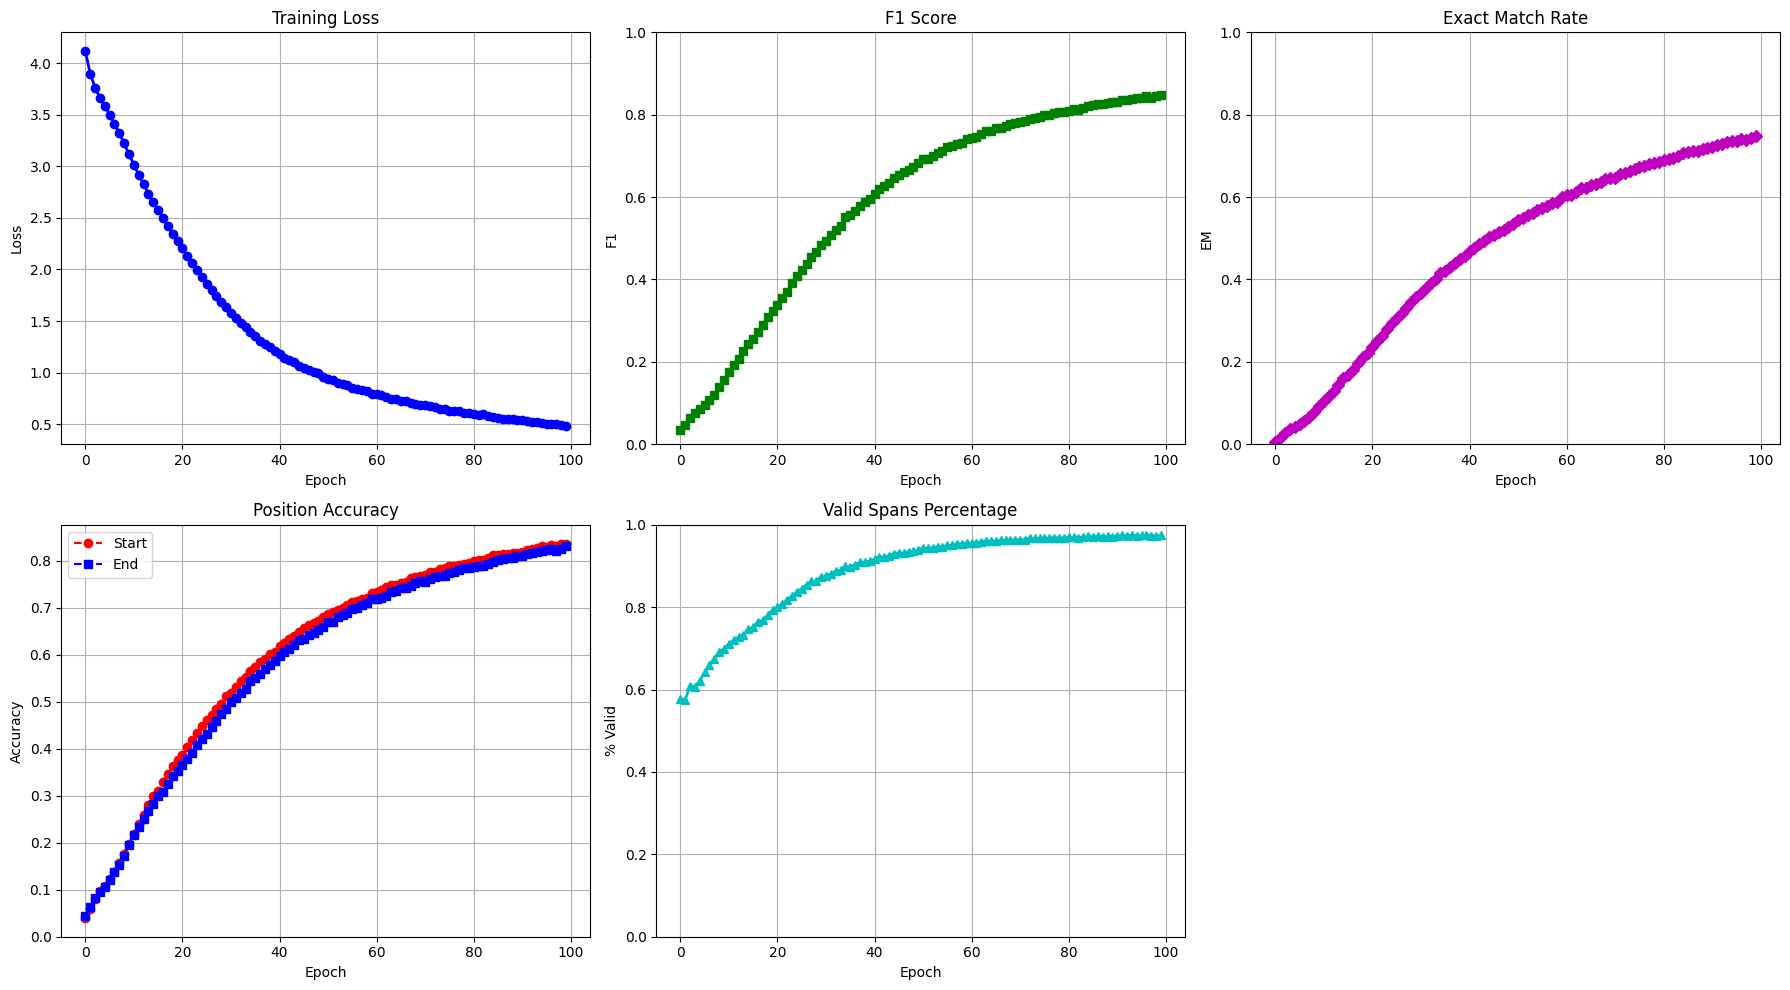

In [ ]:
# Cell 13: Enhanced Visualization
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18, 10))

# Loss and F1
plt.subplot(2, 3, 1)
plt.plot(train_metrics['loss'], 'b-o', linewidth=2)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# F1 Score
plt.subplot(2, 3, 2)
plt.plot(train_metrics['f1'], 'g-s', linewidth=2)
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.ylim(0, 1)
plt.grid(True)

# Exact Match
plt.subplot(2, 3, 3)
plt.plot(train_metrics['em'], 'm-D', linewidth=2)
plt.title('Exact Match Rate')
plt.xlabel('Epoch')
plt.ylabel('EM')
plt.ylim(0, 1)
plt.grid(True)

# Position Accuracy
plt.subplot(2, 3, 4)
plt.plot(train_metrics['start_acc'], 'r--o', label='Start')
plt.plot(train_metrics['end_acc'], 'b--s', label='End')
plt.title('Position Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Valid Spans
plt.subplot(2, 3, 5)
plt.plot(train_metrics['valid'], 'c-^', linewidth=2)
plt.title('Valid Spans Percentage')
plt.xlabel('Epoch')
plt.ylabel('% Valid')
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
print("Max start position:", max(start_positions))
print("Max end position:", max(end_positions))

Max start position: 254
Max end position: 254


In [ ]:
# Cell 8: Prediction Function (Fixed)
def predict(context, question):
    # Tokenize with training-consistent logic
    question_tokens = ['[CLS]'] + simple_tokenizer(question) + ['[SEP]']
    context_tokens = simple_tokenizer(context)

    # Calculate available space (match training exactly)
    available_space = max_length - len(question_tokens) - 1
    context_tokens_truncated = context_tokens[:available_space]
    combined = question_tokens + context_tokens_truncated + ['[SEP]']

    # Convert to IDs and pad to max_length
    input_ids = [vocab.get(token, vocab['[UNK]']) for token in combined]
    input_ids += [vocab['[PAD]']] * (max_length - len(input_ids))

    # Convert to tensor and move to GPU
    input_tensor = torch.tensor([input_ids]).to(device)  # Critical fix

    # Predict
    model.eval()
    with torch.no_grad():
        start_logits, end_logits = model(input_tensor)

    # Get context boundaries
    context_start = len(question_tokens)
    context_end = context_start + len(context_tokens_truncated)

    # Extract logits only for context portion
    start_logits_context = start_logits[0, context_start:context_end]
    end_logits_context = end_logits[0, context_start:context_end]

    # Convert to probabilities
    start_probs = torch.softmax(start_logits_context, dim=-1)
    end_probs = torch.softmax(end_logits_context, dim=-1)

    # Get predicted positions
    start_idx = torch.argmax(start_probs).item()
    end_idx = torch.argmax(end_probs).item()

    # Convert to global positions
    start = context_start + start_idx
    end = context_start + end_idx

    # Force valid span
    start = max(context_start, start)
    end = min(end, context_end - 1)
    end = max(start, end)  # Ensure end >= start

    # Calculate confidence
    start_logp = torch.log_softmax(start_logits_context, dim=-1)[start_idx].item()
    end_logp = torch.log_softmax(end_logits_context, dim=-1)[end_idx].item()
    confidence = np.exp(start_logp + end_logp)

    # Debug prints
    print("\n=== Prediction Debug ===")
    print(f"Question tokens: {question_tokens}")
    print(f"Truncated context tokens: {context_tokens_truncated}")
    print(f"Context span: {context_start}-{context_end-1}")
    print(f"Predicted span (local): {start_idx}-{end_idx}")
    print(f"Predicted span (global): {start}-{end}")
    print(f"Confidence: {confidence:.2%}")

    # Extract and clean answer
    answer_tokens = combined[start:end+1]
    clean_answer = ' '.join([
        token for token in answer_tokens
        if token not in ['[CLS]', '[SEP]', '[PAD]']
    ]).rstrip('.,;?!')

    return clean_answer


In [ ]:
# Test with sample
import numpy as np

sample_context = "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris."
sample_question = "Where is the Eiffel Tower located?"
print("\nFinal Prediction:", predict(sample_context, sample_question))


=== Prediction Debug ===
Question tokens: ['[CLS]', 'where', 'is', 'the', 'eiffel', 'tower', 'located?', '[SEP]']
Truncated context tokens: ['the', 'eiffel', 'tower', 'is', 'a', 'wrought-iron', 'lattice', 'tower', 'on', 'the', 'champ', 'de', 'mars', 'in', 'paris.']
Context span: 8-22
Predicted span (local): 14-14
Predicted span (global): 22-22
Confidence: 96.56%

Final Prediction: paris


In [ ]:
# Test with sample
sample_context = "Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles Crazy in Love and Baby Boy."

sample_question = " When did Beyonce start becoming popular?"
print("\nFinal Prediction:", predict(sample_context, sample_question))


=== Prediction Debug ===
Question tokens: ['[CLS]', 'when', 'did', 'beyonce', 'start', 'becoming', 'popular?', '[SEP]']
Truncated context tokens: ['beyoncé', 'giselle', 'knowles-carter', '(/biːˈjɒnseɪ/', 'bee-yon-say)', '(born', 'september', '4,', '1981)', 'is', 'an', 'american', 'singer,', 'songwriter,', 'record', 'producer', 'and', 'actress.', 'born', 'and', 'raised', 'in', 'houston,', 'texas,', 'she', 'performed', 'in', 'various', 'singing', 'and', 'dancing', 'competitions', 'as', 'a', 'child,', 'and', 'rose', 'to', 'fame', 'in', 'the', 'late', '1990s', 'as', 'lead', 'singer', 'of', 'r&b', 'girl-group', "destiny's", 'child.', 'managed', 'by', 'her', 'father,', 'mathew', 'knowles,', 'the', 'group', 'became', 'one', 'of', 'the', "world's", 'best-selling', 'girl', 'groups', 'of', 'all', 'time.', 'their', 'hiatus', 'saw', 'the', 'release', 'of', "beyoncé's", 'debut', 'album,', 'dangerously', 'in', 'love', '(2003),', 'which', 'established', 'her', 'as', 'a', 'solo', 'artist', 'worldwide

In [ ]:
sample_context = "A self-described modern-day feminist, Beyoncé creates songs that are often characterized by themes of love, relationships, and monogamy, as well as female sexuality and empowerment. On stage, her dynamic, highly choreographed performances have led to critics hailing her as one of the best entertainers in contemporary popular music. Throughout a career spanning 19 years, she has sold over 118 million records as a solo artist, and a further 60 million with Destiny's Child, making her one of the best-selling music artists of all time. She has won 20 Grammy Awards and is the most nominated woman in the award's history. The Recording Industry Association of America recognized her as the Top Certified Artist in America during the 2000s decade. In 2009, Billboard named her the Top Radio Songs Artist of the Decade, the Top Female Artist of the 2000s and their Artist of the Millennium in 2011. Time listed her among the 100 most influential people in the world in 2013 and 2014. Forbes magazine also listed her as the most powerful female musician of 2015."

sample_question ="In her music, what are some recurring elements in them?"
print("\nFinal Prediction:", predict(sample_context, sample_question))


=== Prediction Debug ===
Question tokens: ['[CLS]', 'in', 'her', 'music,', 'what', 'are', 'some', 'recurring', 'elements', 'in', 'them?', '[SEP]']
Truncated context tokens: ['a', 'self-described', 'modern-day', 'feminist,', 'beyoncé', 'creates', 'songs', 'that', 'are', 'often', 'characterized', 'by', 'themes', 'of', 'love,', 'relationships,', 'and', 'monogamy,', 'as', 'well', 'as', 'female', 'sexuality', 'and', 'empowerment.', 'on', 'stage,', 'her', 'dynamic,', 'highly', 'choreographed', 'performances', 'have', 'led', 'to', 'critics', 'hailing', 'her', 'as', 'one', 'of', 'the', 'best', 'entertainers', 'in', 'contemporary', 'popular', 'music.', 'throughout', 'a', 'career', 'spanning', '19', 'years,', 'she', 'has', 'sold', 'over', '118', 'million', 'records', 'as', 'a', 'solo', 'artist,', 'and', 'a', 'further', '60', 'million', 'with', "destiny's", 'child,', 'making', 'her', 'one', 'of', 'the', 'best-selling', 'music', 'artists', 'of', 'all', 'time.', 'she', 'has', 'won', '20', 'grammy'